<a href="https://colab.research.google.com/github/sherifmost/Topology_Mapping/blob/main/Topology_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **About the project**

This is an assignment in the information systems and software course. As simulating large scale network experiments requires lots of physical resources, partitioning can be used. Topology mapping is a partitioning technique that maps the simulated nodes to different physical nodes. In this assignment, we will use spectral clustering to partition a given network topology on the available physical nodes. 

# **What is a network topology?**

The network topology is a graph of N nodes communicating with each other by sending data traffic through a set of edges. An edge in the topology is weighted by the traffic (Mbps) passing through it. *Our clustering technique should find the cut that minimizes the traffic between different partitions.* 

# **About the data**



*   Data set has 30 network topologies with 3 topology sizes (10,50,100 simulated nodes).
*   Each topology is in a .txt file, where each line is an edge in form <from, to, traffic>.


*   Ground truth custering is available for topologies with size 10 and 50, there is a line for each topology ordered by the topology name t_10_0,t_10_1 .. t_50_9. File name is ground_truth.txt.
*   The ground truth line consists of N values (number of nodes), where nodes having the same value are in the same cluster. ie: corresponding clustering labels.





# **Required Library imports**

In [118]:
from google.colab import drive
# used to manipulate the folders containing the images and read them out
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as lg 
# these libraries are used for visualizing the network topology
import networkx as nx
import matplotlib.colors as colors

# **Labels and Constants**

In [20]:
# file paths and file names
data_path = '/content/drive/MyDrive/Information systems/Assignment 2/Dataset';

# the three defined topology sizes
top_small = 10;
top_medium = 50;
top_large = 100;

# defined total number of topologies for each size
top_total = 10;

# the constant delimeters and strings
name_sep = '_';
top_prefix = 't';
delim = '/';
read = 'r';

# some colors for visualizing the topology


# extensions
ext_txt = '.txt';

# **Helper functions**

## Helper functions for visualization

In [258]:
# This function takes in the labels and returns corresponding node colors
# it contains some equations to obtain various colors
def get_node_colors(cluster_labels):
  col_nodes = [];
  # numbers corresponding to rgb should be between 0 and 1 and randomized
  # initialize random numbers corresponding to length of cluster_labels for correctness
  # in any case as it adds a little overhead
  r = np.random.rand(cluster_labels.shape[0]);
  g = np.random.rand(cluster_labels.shape[0]);
  b = np.random.rand(cluster_labels.shape[0]);
  for label in cluster_labels: 
    label = int(label)
    col_nodes.append((r[label],g[label],b[label]));
  return col_nodes;

In [221]:
# This function takes the labels and edges and returns corresponding edge colors
def get_edge_colors(cluster_labels,graph_edges):
  edge_colors = [];
  for edge in graph_edges:
    # make intracluster edge green
    if cluster_labels[edge[0]] == cluster_labels[edge[1]]:
      edge_colors.append('g');
    # make intercluster edge red
    else:
      edge_colors.append('r');
  return edge_colors;

# **Obtaining the data and cleaning it**

In [222]:
# I uploaded the data to google drive as a zip file in order use it here
# Mounting the drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Reading the topologies from the corresponding text file

In [16]:
# size is the corresponding topology size
# top_num is the chosen topology number from 0 to 9 corresponding to the 10 topologies
def read_topology(size,top_num):
  # the topology is implemented as an adjacency matrix of shape n x n where n is number of nodes in the topology
  topology = np.zeros(shape=(size,size));
  # obtaining the file path then reading it line by line to build the topology matrix
  file_path = data_path + delim + top_prefix + name_sep + str(size) + name_sep + str(top_num) + ext_txt;
  top_file = open(file_path,read);
  lines = top_file.readlines();
  for line in lines:
    # parsing the line to obtain the entry
    line_sep = line.split();
    node_from,node_to,weight = [int(line_sep[0]),int(line_sep[1]),int(line_sep[2])];
    # the graph is undirected so 2 entries should be added for the line
    # wights are added beacuse after inspecting the data set, we found that several
    # entries may correspond to connecting the same two nodes.
    topology[node_from - 1][node_to - 1] += weight;
    topology[node_to - 1][node_from - 1] += weight;
  return topology;

In [21]:
# this function is for convinience to read all the topologies of a given size
def read_top_all(size):
  topologies = [];
  for i in range(top_total):
    topologies.append(read_topology(size,i));
  return np.array(topologies);

In [26]:
top_10_0 = read_topology(top_small,0);

# Visualizing the topology


These function use the networkx library to visualize the topology

In [266]:
# given the topology adjacency matrix, an optional title and an optional 
# array of corresponding node cluster labels for annotation in case of having partitioned the topology network
def draw_topology(topology_adj,topology_title = 'Visualizing topology',cluster_labels = [],fig_size=(15,7)):
  # initializing the nodes to be in same cluster in case no clustering happened
  if len(cluster_labels) == 0:
    cluster_labels = np.zeros(shape=(topology_adj.shape[0]));
  # defining a suitable plot size
  plt.figure(figsize = fig_size);
  G = nx.Graph(topology_adj);
  # added to prevent the nodes from being congested in one point as much as possible
  layout = nx.circular_layout(G);
  # adding in the edge labels
  edge_labels = nx.get_edge_attributes(G,'weight')
  nx.draw_networkx_edge_labels(G, pos = layout, edge_labels= edge_labels);
  # adding in the nodes labels numbered conviniently from 1 to size of topology
  # we map each  node to its corresponding label, so x-1 is mapped to x where node labels is a 
  # dictionary.
  node_labels = {x - 1  : x for x in range(1,topology_adj.shape[0] + 1)};
  nx.draw_networkx_labels(G, pos = layout, labels = node_labels,font_color='w',font_weight = 'bold'); 
  # in case clusters were added, we annotate the topology network accordingly
  col_nodes = get_node_colors(cluster_labels);
  col_edges = get_edge_colors(cluster_labels,G.edges);
  # completing the drawing with the corresponding edges and nodes
  nx.draw_networkx_nodes(G, pos = layout, node_color = col_nodes)
  nx.draw_networkx_edges(G, pos = layout, edge_color = col_edges)
  plt.title(topology_title,fontsize = 18);
  plt.show();

# **Scripts to run the functions and obtain required outputs**

## Visualizing a topology network before clustering 

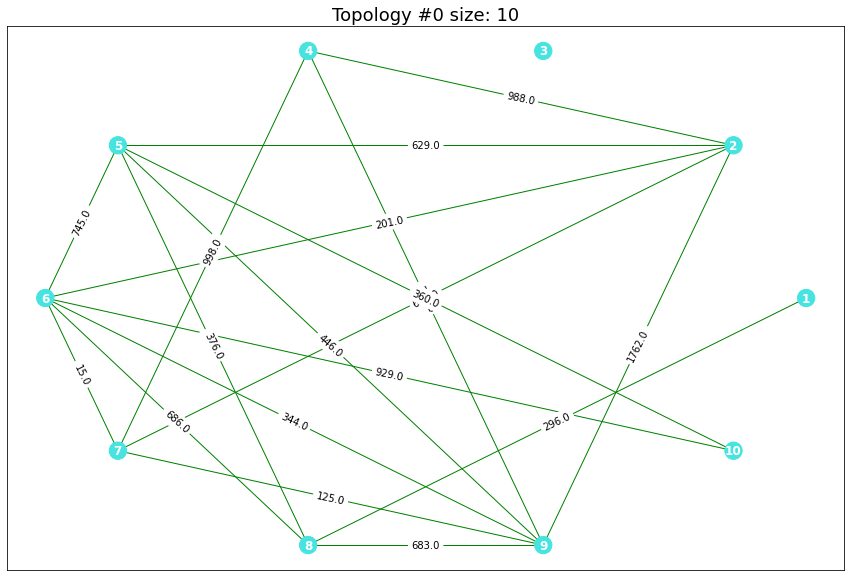

In [271]:
draw_topology(top_10_0,'Topology #0 size: 10',fig_size=(15,10));

## Visualizing the network after clustering

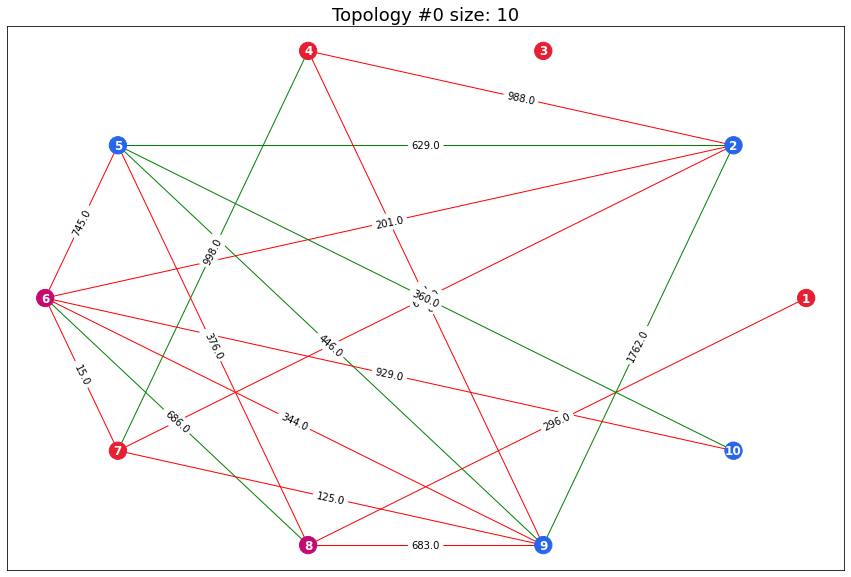

In [272]:
# testing with a pedefined cluster just to see the output
draw_topology(top_10_0,'Topology #0 size: 10',np.array([0,1,0,0,1,2,0,2,1,1]),fig_size = (15,10));